In [1]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime

In [2]:
dataset = load_dataset("csv", 
                       data_files={split: f"../D1/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            "text": Value(dtype="string"),
                            "labels": ClassLabel(names=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"])
                       }))

In [3]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    encoding = tokenizer(examples["text"], max_length=128, truncation=True)

    return encoding

tokenized_dataset = dataset.map(preprocess_data, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [4]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=7)

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [6]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss

In [7]:
raise Exception

Exception: 

In [8]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())
dir_name = "Jan-09-24-20:57:52"

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-6,
    max_grad_norm=1.0,
    num_train_epochs=40,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

trainer = WeightedTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train(resume_from_checkpoint=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6640 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.2877, 'learning_rate': 1.6111111111111111e-06, 'epoch': 11.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5040032863616943, 'eval_WA': 0.4923599320882852, 'eval_UWA': 0.454908657778118, 'eval_miF1': 0.4923599320882852, 'eval_maF1': 0.3685966697610103, 'eval_wtF1': 0.4767503595405065, 'eval_runtime': 0.5062, 'eval_samples_per_second': 2327.365, 'eval_steps_per_second': 37.538, 'epoch': 11.0}
{'loss': 1.2511, 'learning_rate': 1.5555555555555556e-06, 'epoch': 12.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5119973421096802, 'eval_WA': 0.4923599320882852, 'eval_UWA': 0.46145092211397165, 'eval_miF1': 0.4923599320882852, 'eval_maF1': 0.3705848846238483, 'eval_wtF1': 0.4719745600371181, 'eval_runtime': 0.5278, 'eval_samples_per_second': 2231.837, 'eval_steps_per_second': 35.997, 'epoch': 12.0}
{'loss': 1.2137, 'learning_rate': 1.5e-06, 'epoch': 13.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5123941898345947, 'eval_WA': 0.49575551782682514, 'eval_UWA': 0.46822761532885704, 'eval_miF1': 0.49575551782682514, 'eval_maF1': 0.3776090607628552, 'eval_wtF1': 0.4783549908591214, 'eval_runtime': 0.5126, 'eval_samples_per_second': 2298.077, 'eval_steps_per_second': 37.066, 'epoch': 13.0}
{'loss': 1.1793, 'learning_rate': 1.4444444444444443e-06, 'epoch': 14.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.4948216676712036, 'eval_WA': 0.4966044142614601, 'eval_UWA': 0.4832813244553772, 'eval_miF1': 0.4966044142614601, 'eval_maF1': 0.3815994266249959, 'eval_wtF1': 0.48145658092984867, 'eval_runtime': 0.5112, 'eval_samples_per_second': 2304.261, 'eval_steps_per_second': 37.165, 'epoch': 14.0}
{'loss': 1.1412, 'learning_rate': 1.3888888888888887e-06, 'epoch': 15.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5259029865264893, 'eval_WA': 0.4872665534804754, 'eval_UWA': 0.46971885997823665, 'eval_miF1': 0.4872665534804754, 'eval_maF1': 0.3695046411592391, 'eval_wtF1': 0.4728908215539037, 'eval_runtime': 0.5096, 'eval_samples_per_second': 2311.601, 'eval_steps_per_second': 37.284, 'epoch': 15.0}
{'loss': 1.1239, 'learning_rate': 1.3333333333333332e-06, 'epoch': 16.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5272612571716309, 'eval_WA': 0.5, 'eval_UWA': 0.4751960742314342, 'eval_miF1': 0.5, 'eval_maF1': 0.382890897786824, 'eval_wtF1': 0.4843766577458603, 'eval_runtime': 0.5108, 'eval_samples_per_second': 2306.389, 'eval_steps_per_second': 37.2, 'epoch': 16.0}
{'loss': 1.1055, 'learning_rate': 1.2777777777777777e-06, 'epoch': 17.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.548451542854309, 'eval_WA': 0.5033955857385399, 'eval_UWA': 0.46760169375759947, 'eval_miF1': 0.5033955857385399, 'eval_maF1': 0.3828835201662139, 'eval_wtF1': 0.48751336873137235, 'eval_runtime': 0.5111, 'eval_samples_per_second': 2304.899, 'eval_steps_per_second': 37.176, 'epoch': 17.0}
{'loss': 1.0676, 'learning_rate': 1.2222222222222223e-06, 'epoch': 18.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.520138144493103, 'eval_WA': 0.50169779286927, 'eval_UWA': 0.49755032206768324, 'eval_miF1': 0.50169779286927, 'eval_maF1': 0.39531278186151875, 'eval_wtF1': 0.4924848096459081, 'eval_runtime': 0.5124, 'eval_samples_per_second': 2299.103, 'eval_steps_per_second': 37.082, 'epoch': 18.0}
{'loss': 1.0328, 'learning_rate': 1.1666666666666668e-06, 'epoch': 19.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5311346054077148, 'eval_WA': 0.499151103565365, 'eval_UWA': 0.45779310362118275, 'eval_miF1': 0.499151103565365, 'eval_maF1': 0.3808675072539121, 'eval_wtF1': 0.4919940157158269, 'eval_runtime': 0.5083, 'eval_samples_per_second': 2317.666, 'eval_steps_per_second': 37.382, 'epoch': 19.0}
{'loss': 1.0021, 'learning_rate': 1.111111111111111e-06, 'epoch': 20.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5564814805984497, 'eval_WA': 0.5076400679117148, 'eval_UWA': 0.4791543924683371, 'eval_miF1': 0.5076400679117148, 'eval_maF1': 0.39074508851949297, 'eval_wtF1': 0.492370427634328, 'eval_runtime': 0.509, 'eval_samples_per_second': 2314.488, 'eval_steps_per_second': 37.33, 'epoch': 20.0}
{'loss': 1.0115, 'learning_rate': 1.0555555555555555e-06, 'epoch': 21.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.558230996131897, 'eval_WA': 0.49830220713073003, 'eval_UWA': 0.4795605957879799, 'eval_miF1': 0.49830220713073003, 'eval_maF1': 0.3884885873439429, 'eval_wtF1': 0.4882714037893728, 'eval_runtime': 0.5069, 'eval_samples_per_second': 2323.944, 'eval_steps_per_second': 37.483, 'epoch': 21.0}
{'loss': 0.9747, 'learning_rate': 1e-06, 'epoch': 22.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.551967740058899, 'eval_WA': 0.5033955857385399, 'eval_UWA': 0.4875819745688549, 'eval_miF1': 0.5033955857385399, 'eval_maF1': 0.39449730747163625, 'eval_wtF1': 0.491215801283356, 'eval_runtime': 0.5142, 'eval_samples_per_second': 2290.778, 'eval_steps_per_second': 36.948, 'epoch': 22.0}
{'loss': 0.9667, 'learning_rate': 9.444444444444444e-07, 'epoch': 23.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.556207299232483, 'eval_WA': 0.4966044142614601, 'eval_UWA': 0.4772017801731751, 'eval_miF1': 0.4966044142614601, 'eval_maF1': 0.38839165450813895, 'eval_wtF1': 0.48896667351156764, 'eval_runtime': 0.5072, 'eval_samples_per_second': 2322.346, 'eval_steps_per_second': 37.457, 'epoch': 23.0}
{'loss': 0.9394, 'learning_rate': 8.888888888888888e-07, 'epoch': 24.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6006770133972168, 'eval_WA': 0.5110356536502547, 'eval_UWA': 0.4836441189171736, 'eval_miF1': 0.5110356536502547, 'eval_maF1': 0.39869616929985785, 'eval_wtF1': 0.4954525820767382, 'eval_runtime': 0.5077, 'eval_samples_per_second': 2320.458, 'eval_steps_per_second': 37.427, 'epoch': 24.0}
{'loss': 0.9345, 'learning_rate': 8.333333333333333e-07, 'epoch': 25.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6043832302093506, 'eval_WA': 0.5101867572156197, 'eval_UWA': 0.47954776393353027, 'eval_miF1': 0.5101867572156197, 'eval_maF1': 0.396538475958937, 'eval_wtF1': 0.49561129445641483, 'eval_runtime': 0.5098, 'eval_samples_per_second': 2310.821, 'eval_steps_per_second': 37.271, 'epoch': 25.0}
{'loss': 0.9104, 'learning_rate': 7.777777777777778e-07, 'epoch': 26.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6182005405426025, 'eval_WA': 0.5059422750424448, 'eval_UWA': 0.4829484065270019, 'eval_miF1': 0.5059422750424448, 'eval_maF1': 0.40004210211297425, 'eval_wtF1': 0.49785455039217064, 'eval_runtime': 0.5085, 'eval_samples_per_second': 2316.55, 'eval_steps_per_second': 37.364, 'epoch': 26.0}
{'loss': 0.9023, 'learning_rate': 7.222222222222221e-07, 'epoch': 27.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6127246618270874, 'eval_WA': 0.5110356536502547, 'eval_UWA': 0.4834388822206511, 'eval_miF1': 0.5110356536502547, 'eval_maF1': 0.3993364126608468, 'eval_wtF1': 0.5001506385696927, 'eval_runtime': 0.5071, 'eval_samples_per_second': 2322.954, 'eval_steps_per_second': 37.467, 'epoch': 27.0}
{'loss': 0.8889, 'learning_rate': 6.666666666666666e-07, 'epoch': 28.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.626078724861145, 'eval_WA': 0.5059422750424448, 'eval_UWA': 0.47470398765760174, 'eval_miF1': 0.5059422750424448, 'eval_maF1': 0.39393405126927683, 'eval_wtF1': 0.49627068598256796, 'eval_runtime': 0.5198, 'eval_samples_per_second': 2266.384, 'eval_steps_per_second': 36.555, 'epoch': 28.0}
{'loss': 0.8639, 'learning_rate': 6.111111111111112e-07, 'epoch': 29.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6413880586624146, 'eval_WA': 0.5110356536502547, 'eval_UWA': 0.4762138336206902, 'eval_miF1': 0.5110356536502547, 'eval_maF1': 0.3988069607751377, 'eval_wtF1': 0.4988648929665197, 'eval_runtime': 0.5155, 'eval_samples_per_second': 2285.324, 'eval_steps_per_second': 36.86, 'epoch': 29.0}
{'loss': 0.8604, 'learning_rate': 5.555555555555555e-07, 'epoch': 30.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6234732866287231, 'eval_WA': 0.5093378607809848, 'eval_UWA': 0.488544012307364, 'eval_miF1': 0.5093378607809848, 'eval_maF1': 0.4016875772881566, 'eval_wtF1': 0.5022100122199967, 'eval_runtime': 0.5145, 'eval_samples_per_second': 2289.46, 'eval_steps_per_second': 36.927, 'epoch': 30.0}
{'loss': 0.8602, 'learning_rate': 5e-07, 'epoch': 31.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6698514223098755, 'eval_WA': 0.5127334465195246, 'eval_UWA': 0.47171134432932776, 'eval_miF1': 0.5127334465195246, 'eval_maF1': 0.3976552853373988, 'eval_wtF1': 0.5005529622134849, 'eval_runtime': 0.5133, 'eval_samples_per_second': 2294.936, 'eval_steps_per_second': 37.015, 'epoch': 31.0}
{'loss': 0.8528, 'learning_rate': 4.444444444444444e-07, 'epoch': 32.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.658280611038208, 'eval_WA': 0.5118845500848896, 'eval_UWA': 0.48247379089803133, 'eval_miF1': 0.5118845500848896, 'eval_maF1': 0.40373003754342435, 'eval_wtF1': 0.5052857418972072, 'eval_runtime': 0.5096, 'eval_samples_per_second': 2311.488, 'eval_steps_per_second': 37.282, 'epoch': 32.0}
{'loss': 0.8535, 'learning_rate': 3.888888888888889e-07, 'epoch': 33.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.661283016204834, 'eval_WA': 0.5110356536502547, 'eval_UWA': 0.47297450034304445, 'eval_miF1': 0.5110356536502547, 'eval_maF1': 0.3971276428576858, 'eval_wtF1': 0.5036281996151726, 'eval_runtime': 0.5085, 'eval_samples_per_second': 2316.624, 'eval_steps_per_second': 37.365, 'epoch': 33.0}
{'loss': 0.8341, 'learning_rate': 3.333333333333333e-07, 'epoch': 34.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6565821170806885, 'eval_WA': 0.5067911714770797, 'eval_UWA': 0.47263542552650334, 'eval_miF1': 0.5067911714770797, 'eval_maF1': 0.3945408290089772, 'eval_wtF1': 0.49903220951530497, 'eval_runtime': 0.5114, 'eval_samples_per_second': 2303.447, 'eval_steps_per_second': 37.152, 'epoch': 34.0}
{'loss': 0.8392, 'learning_rate': 2.7777777777777776e-07, 'epoch': 35.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6700206995010376, 'eval_WA': 0.5118845500848896, 'eval_UWA': 0.4732126434928017, 'eval_miF1': 0.5118845500848896, 'eval_maF1': 0.3976262485582888, 'eval_wtF1': 0.5015335368990306, 'eval_runtime': 0.5079, 'eval_samples_per_second': 2319.533, 'eval_steps_per_second': 37.412, 'epoch': 35.0}
{'loss': 0.8301, 'learning_rate': 2.222222222222222e-07, 'epoch': 36.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6579370498657227, 'eval_WA': 0.5059422750424448, 'eval_UWA': 0.4656077459811082, 'eval_miF1': 0.5059422750424448, 'eval_maF1': 0.39136469075517244, 'eval_wtF1': 0.49882012372520446, 'eval_runtime': 0.5078, 'eval_samples_per_second': 2319.632, 'eval_steps_per_second': 37.413, 'epoch': 36.0}
{'loss': 0.8225, 'learning_rate': 1.6666666666666665e-07, 'epoch': 37.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6702836751937866, 'eval_WA': 0.5110356536502547, 'eval_UWA': 0.468924478724839, 'eval_miF1': 0.5110356536502547, 'eval_maF1': 0.3959450374720636, 'eval_wtF1': 0.5023649122623393, 'eval_runtime': 0.5132, 'eval_samples_per_second': 2295.271, 'eval_steps_per_second': 37.021, 'epoch': 37.0}
{'loss': 0.8072, 'learning_rate': 1.111111111111111e-07, 'epoch': 38.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6686420440673828, 'eval_WA': 0.5101867572156197, 'eval_UWA': 0.4689994259049216, 'eval_miF1': 0.5101867572156197, 'eval_maF1': 0.39603924952653624, 'eval_wtF1': 0.502518860634019, 'eval_runtime': 0.5108, 'eval_samples_per_second': 2306.258, 'eval_steps_per_second': 37.198, 'epoch': 38.0}
{'loss': 0.8068, 'learning_rate': 5.555555555555555e-08, 'epoch': 39.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6707849502563477, 'eval_WA': 0.5067911714770797, 'eval_UWA': 0.4655327988010256, 'eval_miF1': 0.5067911714770797, 'eval_maF1': 0.39220080192657436, 'eval_wtF1': 0.49797585756378515, 'eval_runtime': 0.5144, 'eval_samples_per_second': 2289.891, 'eval_steps_per_second': 36.934, 'epoch': 39.0}
{'loss': 0.8083, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6712801456451416, 'eval_WA': 0.5076400679117148, 'eval_UWA': 0.46636061337056206, 'eval_miF1': 0.5076400679117148, 'eval_maF1': 0.3931420767741745, 'eval_wtF1': 0.4984446041185553, 'eval_runtime': 0.5158, 'eval_samples_per_second': 2283.707, 'eval_steps_per_second': 36.834, 'epoch': 40.0}
{'train_runtime': 511.2439, 'train_samples_per_second': 826.298, 'train_steps_per_second': 12.988, 'train_loss': 0.7243046588208302, 'epoch': 40.0}


TrainOutput(global_step=6640, training_loss=0.7243046588208302, metrics={'train_runtime': 511.2439, 'train_samples_per_second': 826.298, 'train_steps_per_second': 12.988, 'train_loss': 0.7243046588208302, 'epoch': 40.0})

In [ ]:
raise Exception

Exception: 

In [9]:
trainer.evaluate(tokenized_dataset["test"])

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 1.383486270904541,
 'eval_WA': 0.5108538350217077,
 'eval_UWA': 0.5227564730339125,
 'eval_miF1': 0.5108538350217077,
 'eval_maF1': 0.3838406290096717,
 'eval_wtF1': 0.5086526097894983,
 'eval_runtime': 1.2526,
 'eval_samples_per_second': 2206.683,
 'eval_steps_per_second': 35.128,
 'epoch': 40.0}

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [ ]:
preds

,text,labels,pred
0,Why do all you're coffee mugs have numbers on ...,5,5
1,Oh. That's so Monica can keep track. That way ...,7,0
2,Y'know what?,0,0
3,It didn't.,0,0
4,"Okay, so what you used to have with Rachel, is...",1,0
...,...,...,...
2759,"Hey, why don't you guys go get portraits done ...",0,0
2760,That's a good idea! I bet they have one of tho...,1,1
2761,"Yeah that's great! Next to that, Chandler won'...",0,1
2762,Chandler what do you say?,0,0


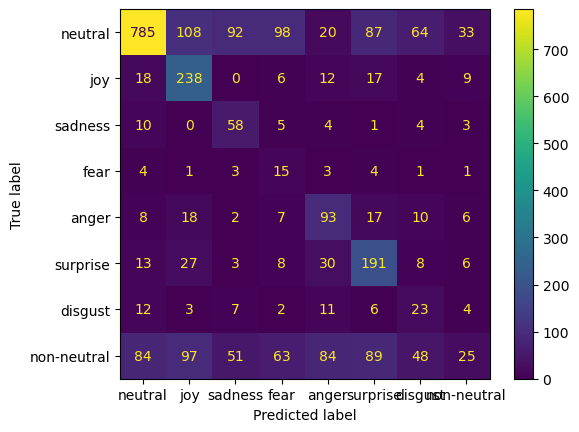

In [ ]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)